# ***EDA Sistema de recomendación***

## * El modelo mejoro mucho subiendo a un nivel de efectividad del 62% con Region Lineal  

### aunque se probaron multiples modelos entre ellos Random Forest, SVM y Gaussian NB
* Arrojaron  un score propendió entre los modelos del 30%
* solo permitían un conjunto de palabras no mayor a 5000 ya que pedía mas memoria ram en maquina.
* El modelo con regresión lineal soporto las 20.824 palabras


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import nltk
#import itertools
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from nltk.corpus import wordnet
import joblib
import fastparquet
import pickle
#nltk.download('punkt')
#nltk.download('stopwords')


## Data = Columna "title"<br>
## target = Columna "vote_average"<br>

In [3]:
df = pd.read_csv("./DataSet/movies_dataset_Para_EDA.csv")

In [4]:
df.count()

title           42388
vote_average    42388
dtype: int64

In [46]:
df.columns

Index(['title', 'vote_average', 'title_lemmatizer'], dtype='object')

In [6]:

plReco = df[["title", 'vote_average']][df['title'].str.contains("Robin")]
plReco = plReco.sort_values(by='vote_average', ascending= False)  
plReco.head(5)    

title  vote_average
26213         The Court-Martial of Jackie Robinson            10
877                   The Adventures of Robin Hood             7
24788  Robin Williams: Weapons of Self Destruction             7
949                          Swiss Family Robinson             7
40709             Robin Williams: Live on Broadway             7

In [45]:
df["vote_average"].unique()

array([ 7,  6,  5,  3,  8,  4,  2, 10,  9,  1], dtype=int64)

## ***1- ANÁLISIS DE COLECCIÓN***

In [8]:
df.head()

title  vote_average
0                    Toy Story             7
1                      Jumanji             6
2             Grumpier Old Men             6
3            Waiting to Exhale             6
4  Father of the Bride Part II             5

In [9]:
df.shape

(42388, 2)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42388 entries, 0 to 42387
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         42388 non-null  object
 1   vote_average  42388 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 662.4+ KB


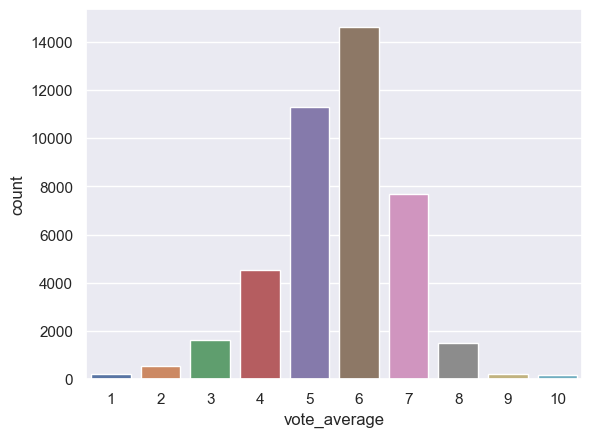

In [11]:
sns.countplot(x= "vote_average", data = df )
plt.show()

## ***2- Exploración de datos***

In [12]:
index_random_titulo_pelicula = np.random.randint(0, high= df.shape[0])
titulo_pelicula = df.iloc[index_random_titulo_pelicula].title
print(index_random_titulo_pelicula, titulo_pelicula)

30890 Taxi No. 9 2 11: Nau Do Gyarah


In [13]:
print(index_random_titulo_pelicula, df.iloc[index_random_titulo_pelicula].vote_average)

30890 6


## ***3- NLTK***

In [14]:
## Tokenizar por palabras
titulo_wk = nltk.tokenize.word_tokenize(titulo_pelicula)
titulo_wk

['Taxi', 'No', '.', '9', '2', '11', ':', 'Nau', 'Do', 'Gyarah']

In [15]:
## re Exprecion regular 
import re
titular_wt = nltk.tokenize.word_tokenize("El día de ayer fue el día más lluvioso del año!!.".lower())
re.sub("[^a-zA-Z!ñíá]"," ",str(titular_wt))

'  el    día    de    ayer    fue    el    día    más    lluvioso    del    año    !    !       '

### Normalizar

In [16]:
# Diccionario de palabras inutilies en ingles es 'english' en español es 'apanish'
stopwords = nltk.corpus.stopwords.words('english')
stopwords = [palabra for palabra in stopwords if 'not' not in palabra]
stopwords
stopwords.append(":") # agregar una palabra inútil
filtrar = []
if True:
    filtrar.append("u")
    filtrar.append("new")

In [17]:
titulo_wk

['Taxi', 'No', '.', '9', '2', '11', ':', 'Nau', 'Do', 'Gyarah']

In [18]:
# Eliminar palabras inútiles
titulo_wk_sin_sw = [word for word in titulo_wk if word not in stopwords]
titulo_wk_sin_sw

['Taxi', 'No', '.', '9', '2', '11', 'Nau', 'Do', 'Gyarah']

In [19]:
titulo_wk = nltk.tokenize.word_tokenize(titulo_pelicula)
titulo_wk

['Taxi', 'No', '.', '9', '2', '11', ':', 'Nau', 'Do', 'Gyarah']

# 4. Stemming => palabra raiz

In [20]:


def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [21]:
# Normalizamos el texto

stopwords = nltk.corpus.stopwords.words('english')


In [22]:
# Recorremos todos los titulos y le vamos aplicando la Normalizacion y luega el Stemming a cada uno
titulo_list=[]
for titulo in df.title:
    # Vamos a reemplazar los caracteres que no sean leras por espacios
    titulo=re.sub("[^a-zA-Z]"," ",str(titulo))
    # Pasamos todo a minúsculas
    titulo=titulo.lower()
    # Tokenizamos para separar las palabras del titular
    titulo=nltk.word_tokenize(titulo)

    # Aplicamos el Lemmatizer (Esto puede tardar un ratito)
    frase_lemma = [wordnet_lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in titulo]


    # Eliminamos las palabras de menos de 3 letras
    titulo = [palabra for palabra in titulo if len(palabra)>2]
    # Sacamos las Stopwords
    titulo = [palabra for palabra in titulo if not palabra in stopwords]
    
    ## Hasta acá Normalizamos, ahora a stemmizar
    
    # Aplicamos la funcion para buscar la raiz de las palabras
    #titulo=[stemmer.stem(palabra) for palabra in titulo]
    # Por ultimo volvemos a unir el titular
    titulo=" ".join(titulo)
    
    # Vamos armando una lista con todos los titulares
    titulo_list.append(titulo)
    #dataset["titular_normalizado"] = titular_list

In [23]:
titulo_list

['toy story',
 'jumanji',
 'grumpier old men',
 'waiting exhale',
 'father bride part',
 'heat',
 'sabrina',
 'tom huck',
 'sudden death',
 'goldeneye',
 'american president',
 'dracula dead loving',
 'balto',
 'nixon',
 'cutthroat island',
 'casino',
 'sense sensibility',
 'four rooms',
 'ace ventura nature calls',
 'money train',
 'get shorty',
 'copycat',
 'assassins',
 'powder',
 'leaving las vegas',
 'othello',
 '',
 'persuasion',
 'city lost children',
 'shanghai triad',
 'dangerous minds',
 'twelve monkeys',
 'wings courage',
 'babe',
 'carrington',
 'dead man walking',
 'across sea time',
 'takes two',
 'clueless',
 'cry beloved country',
 'richard iii',
 'dead presidents',
 'restoration',
 'mortal kombat',
 'die',
 'make american quilt',
 '',
 'pocahontas',
 'night falling',
 'usual suspects',
 'guardian angel',
 'mighty aphrodite',
 'lamerica',
 'big green',
 'georgia',
 'kids round table',
 'home holidays',
 'postman',
 'confessional',
 'indian cupboard',
 'eye eye',
 'holla

In [24]:
df["title_lemmatizer"] = titulo_list

In [25]:
df.head(10)

title  vote_average   title_lemmatizer
0                    Toy Story             7          toy story
1                      Jumanji             6            jumanji
2             Grumpier Old Men             6   grumpier old men
3            Waiting to Exhale             6     waiting exhale
4  Father of the Bride Part II             5  father bride part
5                         Heat             7               heat
6                      Sabrina             6            sabrina
7                 Tom and Huck             5           tom huck
8                 Sudden Death             5       sudden death
9                    GoldenEye             6          goldeneye

## 6. Vectorizar

In [26]:
df.head(10)

title  vote_average   title_lemmatizer
0                    Toy Story             7          toy story
1                      Jumanji             6            jumanji
2             Grumpier Old Men             6   grumpier old men
3            Waiting to Exhale             6     waiting exhale
4  Father of the Bride Part II             5  father bride part
5                         Heat             7               heat
6                      Sabrina             6            sabrina
7                 Tom and Huck             5           tom huck
8                 Sudden Death             5       sudden death
9                    GoldenEye             6          goldeneye

#### a. Dividimos el Data Set entre el title_lemmatizer en una lista y vote_average con .values

In [27]:
df.title_lemmatizer[0]

'toy story'

In [28]:
list_title_lemmatizer = list(df["title_lemmatizer"].values)
is_vote = df["vote_average"].values

## 7. Modelar

Ahroa sí estamos listos para usar todo nuestro conocimiento de modelos en este set de datos. Tengamos en cuenta que, dependiendo el número de palabras (features) que hayamos elegido, los modelos pueden tardar un rato en entrenarse.



## Regresión lineal

In [29]:
list_title_lemmatizer

['toy story',
 'jumanji',
 'grumpier old men',
 'waiting exhale',
 'father bride part',
 'heat',
 'sabrina',
 'tom huck',
 'sudden death',
 'goldeneye',
 'american president',
 'dracula dead loving',
 'balto',
 'nixon',
 'cutthroat island',
 'casino',
 'sense sensibility',
 'four rooms',
 'ace ventura nature calls',
 'money train',
 'get shorty',
 'copycat',
 'assassins',
 'powder',
 'leaving las vegas',
 'othello',
 '',
 'persuasion',
 'city lost children',
 'shanghai triad',
 'dangerous minds',
 'twelve monkeys',
 'wings courage',
 'babe',
 'carrington',
 'dead man walking',
 'across sea time',
 'takes two',
 'clueless',
 'cry beloved country',
 'richard iii',
 'dead presidents',
 'restoration',
 'mortal kombat',
 'die',
 'make american quilt',
 '',
 'pocahontas',
 'night falling',
 'usual suspects',
 'guardian angel',
 'mighty aphrodite',
 'lamerica',
 'big green',
 'georgia',
 'kids round table',
 'home holidays',
 'postman',
 'confessional',
 'indian cupboard',
 'eye eye',
 'holla

In [30]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
vector = CountVectorizer()
vector.fit(list_title_lemmatizer)


CountVectorizer()

In [31]:
# nos muestra los token de nuestro sed de datos
token = vector.vocabulary_  
print(token)
#print(type(token))



{'toy': 18886, 'story': 17675, 'jumanji': 9591, 'grumpier': 7764, 'old': 13137, 'men': 11722, 'waiting': 19988, 'exhale': 6080, 'father': 6305, 'bride': 2413, 'part': 13589, 'heat': 8202, 'sabrina': 15822, 'tom': 18759, 'huck': 8660, 'sudden': 17845, 'death': 4614, 'goldeneye': 7519, 'american': 492, 'president': 14444, 'dracula': 5311, 'dead': 4590, 'loving': 10916, 'balto': 1330, 'nixon': 12854, 'cutthroat': 4386, 'island': 9220, 'casino': 3007, 'sense': 16340, 'sensibility': 16343, 'four': 6818, 'rooms': 15632, 'ace': 107, 'ventura': 19690, 'nature': 12610, 'calls': 2775, 'money': 12137, 'train': 18922, 'get': 7293, 'shorty': 16647, 'copycat': 4011, 'assassins': 976, 'powder': 14363, 'leaving': 10454, 'las': 10340, 'vegas': 19657, 'othello': 13309, 'persuasion': 13869, 'city': 3499, 'lost': 10872, 'children': 3348, 'shanghai': 16494, 'triad': 19020, 'dangerous': 4499, 'minds': 11931, 'twelve': 19225, 'monkeys': 12155, 'wings': 20347, 'courage': 4110, 'babe': 1186, 'carrington': 2965

In [32]:
len(token)

20824

In [33]:
# creamos data set para  el modelo predictivo

keys = list(token.keys())
values = list(token.values())
dictionary = dict(zip(keys, values))
#dictionary = {key: [0] for key in keys}
#type(dictionary)
dictionary


{'toy': 18886,
 'story': 17675,
 'jumanji': 9591,
 'grumpier': 7764,
 'old': 13137,
 'men': 11722,
 'waiting': 19988,
 'exhale': 6080,
 'father': 6305,
 'bride': 2413,
 'part': 13589,
 'heat': 8202,
 'sabrina': 15822,
 'tom': 18759,
 'huck': 8660,
 'sudden': 17845,
 'death': 4614,
 'goldeneye': 7519,
 'american': 492,
 'president': 14444,
 'dracula': 5311,
 'dead': 4590,
 'loving': 10916,
 'balto': 1330,
 'nixon': 12854,
 'cutthroat': 4386,
 'island': 9220,
 'casino': 3007,
 'sense': 16340,
 'sensibility': 16343,
 'four': 6818,
 'rooms': 15632,
 'ace': 107,
 'ventura': 19690,
 'nature': 12610,
 'calls': 2775,
 'money': 12137,
 'train': 18922,
 'get': 7293,
 'shorty': 16647,
 'copycat': 4011,
 'assassins': 976,
 'powder': 14363,
 'leaving': 10454,
 'las': 10340,
 'vegas': 19657,
 'othello': 13309,
 'persuasion': 13869,
 'city': 3499,
 'lost': 10872,
 'children': 3348,
 'shanghai': 16494,
 'triad': 19020,
 'dangerous': 4499,
 'minds': 11931,
 'twelve': 19225,
 'monkeys': 12155,
 'wings':

In [34]:
data_set_pred = pd.DataFrame(dictionary, index=[0])
data_set_pred.shape
data_set_pred.to_parquet('./DataSet/token.parquet')

In [35]:
data_set_pred

toy  story  jumanji  grumpier    old    men  waiting  exhale  father   
0  18886  17675     9591      7764  13137  11722    19988    6080    6305  \

   bride  ...  princezna  phobos  scheming  posters  devilish  untameable   
0   2413  ...      14490   13950     16122    14332      4913       19454  \

   imperceptable  transmutations  burkittsville  birthing  
0           8888           18953           2626      1888  

[1 rows x 20824 columns]

In [36]:
len(dictionary)

20824

In [37]:
dictionary

{'toy': 18886,
 'story': 17675,
 'jumanji': 9591,
 'grumpier': 7764,
 'old': 13137,
 'men': 11722,
 'waiting': 19988,
 'exhale': 6080,
 'father': 6305,
 'bride': 2413,
 'part': 13589,
 'heat': 8202,
 'sabrina': 15822,
 'tom': 18759,
 'huck': 8660,
 'sudden': 17845,
 'death': 4614,
 'goldeneye': 7519,
 'american': 492,
 'president': 14444,
 'dracula': 5311,
 'dead': 4590,
 'loving': 10916,
 'balto': 1330,
 'nixon': 12854,
 'cutthroat': 4386,
 'island': 9220,
 'casino': 3007,
 'sense': 16340,
 'sensibility': 16343,
 'four': 6818,
 'rooms': 15632,
 'ace': 107,
 'ventura': 19690,
 'nature': 12610,
 'calls': 2775,
 'money': 12137,
 'train': 18922,
 'get': 7293,
 'shorty': 16647,
 'copycat': 4011,
 'assassins': 976,
 'powder': 14363,
 'leaving': 10454,
 'las': 10340,
 'vegas': 19657,
 'othello': 13309,
 'persuasion': 13869,
 'city': 3499,
 'lost': 10872,
 'children': 3348,
 'shanghai': 16494,
 'triad': 19020,
 'dangerous': 4499,
 'minds': 11931,
 'twelve': 19225,
 'monkeys': 12155,
 'wings':

In [38]:
bolsa = vector.transform(list_title_lemmatizer)
bolsay = is_vote

In [39]:
xtrain, xtest, ytrain, ytest = train_test_split(bolsa,bolsay,test_size=0.2,random_state=42)#,stratify=y)

In [40]:
lr = LogisticRegression()

In [41]:
lr.fit(xtrain,ytrain)

C:\Users\Alberto\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [42]:
lr.score(xtrain,ytrain)

0.6105868475375995

## SVM

In [43]:
# Notar que en vez de utilizar SVC, vamos a usar LinearSVC. 
# Para el Kernel Lineal, esta función es MUCHO mas rapida que la tradicional SVC.
from sklearn.svm import LinearSVC

svc = LinearSVC(C = 1)
svc.fit(xtrain,ytrain)
svc.score(xtest,ytest)

0.29712196272705826

### 8 - Guardamos el modelo Regresión Lineal ya entrenado  
* soporta la totalidad de las palabras encontradas en el  DataSet y nos entrega la mejor confiabilidad del 75%

In [44]:
joblib.dump(lr, "./DataSet/prediccion_rl.pkl", compress= 1)
joblib.dump(svc, "./DataSet/prediccion_SVC.pkl", compress= 1)
#with open("./DataSet/prediccion_rl_pk.plk", 'wb') as archivo:
#    pickle.dump(lr, archivo)


['./DataSet/prediccion_SVC.pkl']